# Notebook Goals

## This notebook will attempt to answer the first prompt provided by the dataset contributor.

### How many customers are spending more over time? Less over time? Describe these customers.
### Of those customers who are spending more over time, which categories are growing at a faster rate?

### To answer these questions we will use the four of the files provided:
        1. transaction data
        2. hh_demographic
        3. campaign_table
        4. campaign_desc
        
## Notebook Structure

1. The notebook will look at households that the dataset provides transaction and demographic data for. 

2. From there we will breakout the households out by age groups and income group. 

3. Plot Average Weekly Spending for all age and income groups.

4. Plot Average Weekly Spending for a specific demographic group: Age Group (15-34) and Income Group 50-74K. 

5. Chart the spending patterns of two specific households during the active adveristing campaigns.

6. How do you define a successful campaign? Increase customer spending? Or increased customer visit?  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Load the Data

In [2]:
# campaign_desc = pd.read_csv('/kaggle/input/dunnhumby-the-complete-journey/campaign_desc.csv')
# product = pd.read_csv('/kaggle/input/dunnhumby-the-complete-journey/product.csv')
# coupon_redempt = pd.read_csv('/kaggle/input/dunnhumby-the-complete-journey/coupon_redempt.csv')
# transaction_data = pd.read_csv('/kaggle/input/dunnhumby-the-complete-journey/transaction_data.csv')
# hh_demographic = pd.read_csv('/kaggle/input/dunnhumby-the-complete-journey/hh_demographic.csv')
# coupon = pd.read_csv('/kaggle/input/dunnhumby-the-complete-journey/coupon.csv')
# campaign_table = pd.read_csv('/kaggle/input/dunnhumby-the-complete-journey/campaign_table.csv')
# causal_data = pd.read_csv('/kaggle/input/dunnhumby-the-complete-journey/causal_data.csv')

In [3]:
campaign_desc = pd.read_csv('CSV-Files/campaign_desc.csv')
product = pd.read_csv('CSV-Files/product.csv')
coupon_redempt = pd.read_csv('CSV-Files/coupon_redempt.csv')
transaction_data = pd.read_csv('CSV-Files/transaction_data.csv')
hh_demographic = pd.read_csv('CSV-Files/hh_demographic.csv')
coupon = pd.read_csv('CSV-Files/coupon.csv')
campaign_table = pd.read_csv('CSV-Files/campaign_table.csv')
causal_data = pd.read_csv('CSV-Files/causal_data.csv')

# 1. Finding households that have transaction data and demographic data available.

In [4]:
#  Get a list of all unique household keys in transaction_data
trans_data_hh_key_list = list(transaction_data.household_key.unique())

#  Get a list of all unique household keys in hh_demoographics
hh_demo_hh_key_list = list(hh_demographic.household_key.unique())

In [5]:
## A function to find common items in two lists

def common_member(a, b): 
    """A function to find the common items in two lists."""
    a_set = set(a) 
    b_set = set(b) 
    if (a_set & b_set): 
        return list((a_set & b_set))
    else: 
        print("No common elements")

In [6]:
#  Create a list of unique household keys that transaction data AND demographic data is avaliable for.
trans_data_and_hh_demo_hh_keys_list = common_member(trans_data_hh_key_list, hh_demo_hh_key_list)

#  Print the length of the list so we know the amount of household we have avaliable data for
print("We have transaction AND demongraphic data on " + str(len(trans_data_and_hh_demo_hh_keys_list)) + " households.")

We have transaction AND demongraphic data on 801 households.


## Quick look at the transaction data

In [7]:
transaction_data.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


## Quick look at the household demographics data

In [8]:
hh_demographic.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


### Transaction Data and Household Demographics Notes:

Both data sets share a common column value the household keys. This means we can match the products by each household use the two dataframes.

Additionally it is importand to note that in the transction dataset, each row represents a single product that has an accompanying basket_id. Each all products that shares the same basket_id have the same transaction timestamp, day, and week. 

This means we can think of each household having a varying number of transaction (represented by the different basket_id) and each basket containing a different set of products.

The following code block groups the transaction_data by household_key and basket_ID. It the sums the total sales value of each transaction.

In [9]:
trans_data_baskets_hh_key = pd.DataFrame(transaction_data.groupby(['household_key', 'BASKET_ID']).sum()).drop(['DAY', 'PRODUCT_ID','QUANTITY', 'STORE_ID', 'RETAIL_DISC', 'TRANS_TIME', 'WEEK_NO', 'COUPON_DISC', 'COUPON_MATCH_DISC'], axis=1)
trans_data_baskets_hh_key = trans_data_baskets_hh_key.merge(transaction_data.drop(['SALES_VALUE', 'PRODUCT_ID', 'QUANTITY', 'RETAIL_DISC', 'COUPON_DISC', 'COUPON_MATCH_DISC'], axis=1), on="BASKET_ID").drop_duplicates(subset=['BASKET_ID'])
trans_data_baskets_hh_key.head()

,BASKET_ID,SALES_VALUE,household_key,DAY,STORE_ID,TRANS_TIME,WEEK_NO
0,27601281299,78.66,1,51,436,1456,8
30,27774192959,41.10,1,67,436,2002,10
42,28024266849,26.90,1,88,436,1604,13
54,28106322445,63.43,1,94,436,1937,14
77,28235481967,53.45,1,101,436,1603,15


### Merging transaction baskets with demogrpahic data

Since the transaction data provides a household key with each basket_id, we can match household demographic data to each transaction basket using the follwing block of code.

In [10]:
spend_demo_data = trans_data_baskets_hh_key.merge(hh_demographic, on='household_key')
spend_demo_data.head()

,BASKET_ID,SALES_VALUE,household_key,DAY,STORE_ID,TRANS_TIME,WEEK_NO,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
0,27601281299,78.66,1,51,436,1456,8,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
1,27774192959,41.10,1,67,436,2002,10,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
2,28024266849,26.90,1,88,436,1604,13,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
3,28106322445,63.43,1,94,436,1937,14,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
4,28235481967,53.45,1,101,436,1603,15,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown


### SANITY CHECK:

Earlier we used a function to find the list of household_keys that we had both transaction_data and demographic data. The following codeblock will verifiy that the household keys in the spending demographic dataset matches the list we created earliers.

The code block returns true if the sorted list household keys we created previously matches the sorted list of unique household keys in the spending and demographic datasets we just created.

Alternatively, we could use the household keys from the first list to filter through the transaction and demographics dataset, separately than join the two filtered datasets together.

In [11]:
print(sorted(trans_data_and_hh_demo_hh_keys_list) == sorted(list(spend_demo_data.household_key.unique())))

# Print the length of the list of household keys to verify the length matches as well. 
len(list(spend_demo_data.household_key.unique()))

True


801

# 2. Sorting Spending Demographic Data by Age Group and Income Group

The following blocks of code finds the unique age groups and income groups listed under the AGE_DESC and INCOME_DESC columns, respectively, in the spend_demo_data set and creates individual dataframes for each age and income group.

In [12]:
#  Get the unique age_groups in AGE_DSC
age_groups = sorted(list(spend_demo_data.AGE_DESC.unique()))
print("The different age_group buckets in the dataset are " + str(age_groups) + ".")

# Create empty list of to store dataframes
age_group_spending_dfs = []

# append each individual age group dataframe to the list
for group in age_groups:
    age_group_spending_dfs.append(spend_demo_data[spend_demo_data['AGE_DESC'] == group])
    
    
# Group and Name the Transaction Spending DataFrames by Age Group
age_19_24 = age_group_spending_dfs[0]
age_25_34 = age_group_spending_dfs[1]
age_35_44 = age_group_spending_dfs[2]
age_45_54 = age_group_spending_dfs[3]
age_55_64 = age_group_spending_dfs[4]
age_65 = age_group_spending_dfs[5]

The different age_group buckets in the dataset are ['19-24', '25-34', '35-44', '45-54', '55-64', '65+'].


In [13]:
#  Get the unique age_groups in INCOME_DESC
income_groups = sorted(list(spend_demo_data.INCOME_DESC.unique()))
print("The different income buckets in the dataset are " + str(income_groups) + ".")

# Create empty list of to store dataframes
income_group_spending_dfs = []

# append each individual age group dataframe to the list
for group in income_groups:
    income_group_spending_dfs.append(spend_demo_data[spend_demo_data['INCOME_DESC'] == group])
    

#  Group and Name the Transaction Spending DataFrames by Income Group
inc_100_124K = income_group_spending_dfs[0]
inc_125_149K = income_group_spending_dfs[1]
inc_15_24K = income_group_spending_dfs[2]
inc_150_174K = income_group_spending_dfs[3]
inc_175_199K = income_group_spending_dfs[4]
inc_200_249K = income_group_spending_dfs[5]
inc_25_34K = income_group_spending_dfs[6]
inc_250K = income_group_spending_dfs[7]
inc_35_49K = income_group_spending_dfs[8]
inc_50_74K = income_group_spending_dfs[9]
inc_75_99K = income_group_spending_dfs[10]
inc_Under_15K = income_group_spending_dfs[11]

The different income buckets in the dataset are ['100-124K', '125-149K', '15-24K', '150-174K', '175-199K', '200-249K', '25-34K', '250K+', '35-49K', '50-74K', '75-99K', 'Under 15K'].


# 3. Plotting Weekly Spending by Age and Income Groups

## Weekly Spending By Age Groups

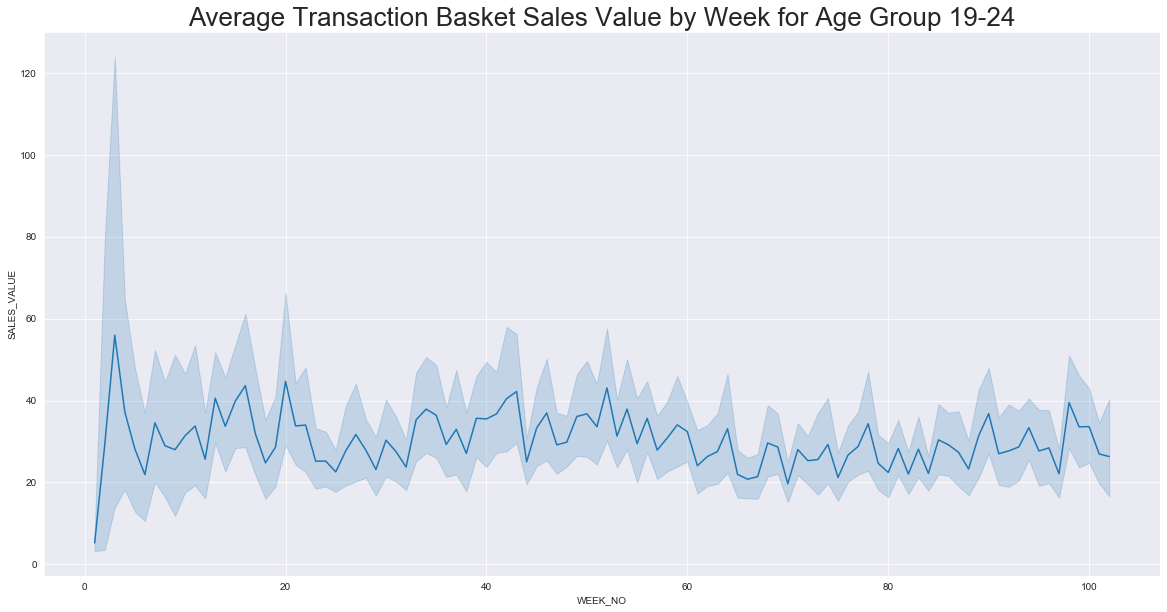

In [14]:
sns.set_style("darkgrid")

avg_weekly_sales_19_24 = age_19_24[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Age Group 19-24", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_19_24,
                  markers=True)

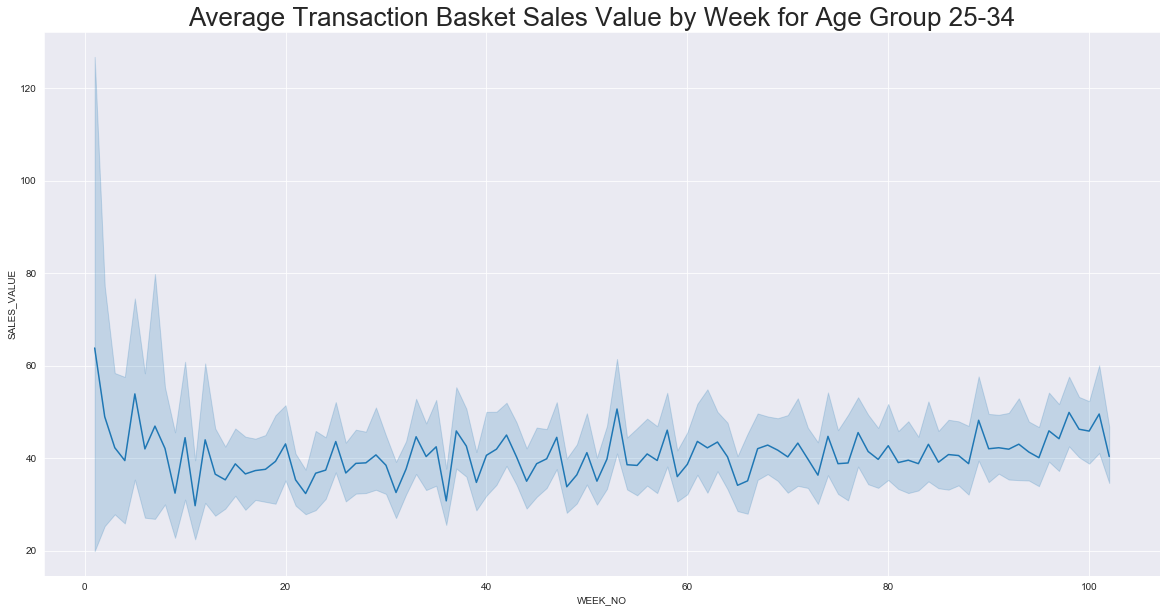

In [15]:
sns.set_style("darkgrid")

avg_weekly_sales_25_34 = age_25_34[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Age Group 25-34", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_25_34,
                  markers=True)

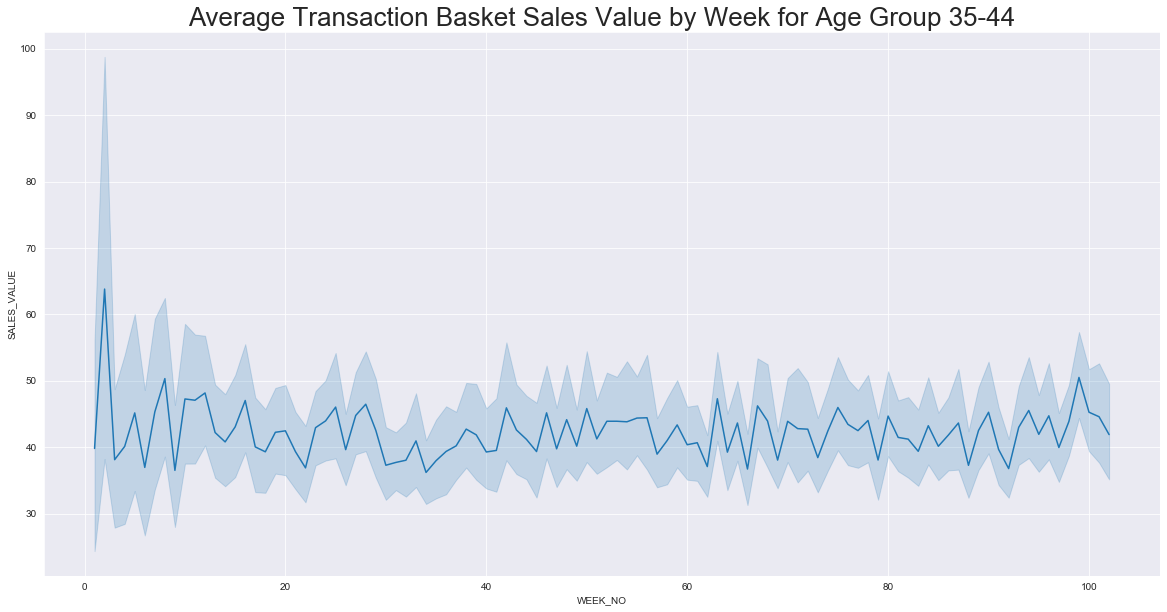

In [16]:
sns.set_style("darkgrid")

avg_weekly_sales_35_44 = age_35_44[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Age Group 35-44", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_35_44,
                  markers=True)

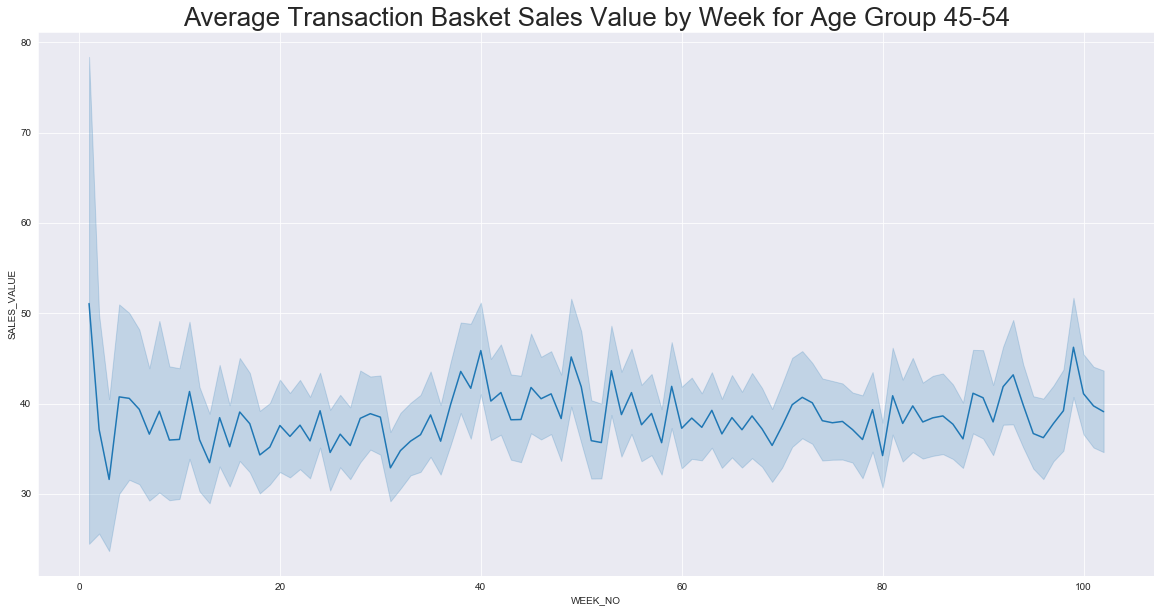

In [17]:
sns.set_style("darkgrid")

avg_weekly_sales_45_54 = age_45_54[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Age Group 45-54", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_45_54,
                  markers=True)

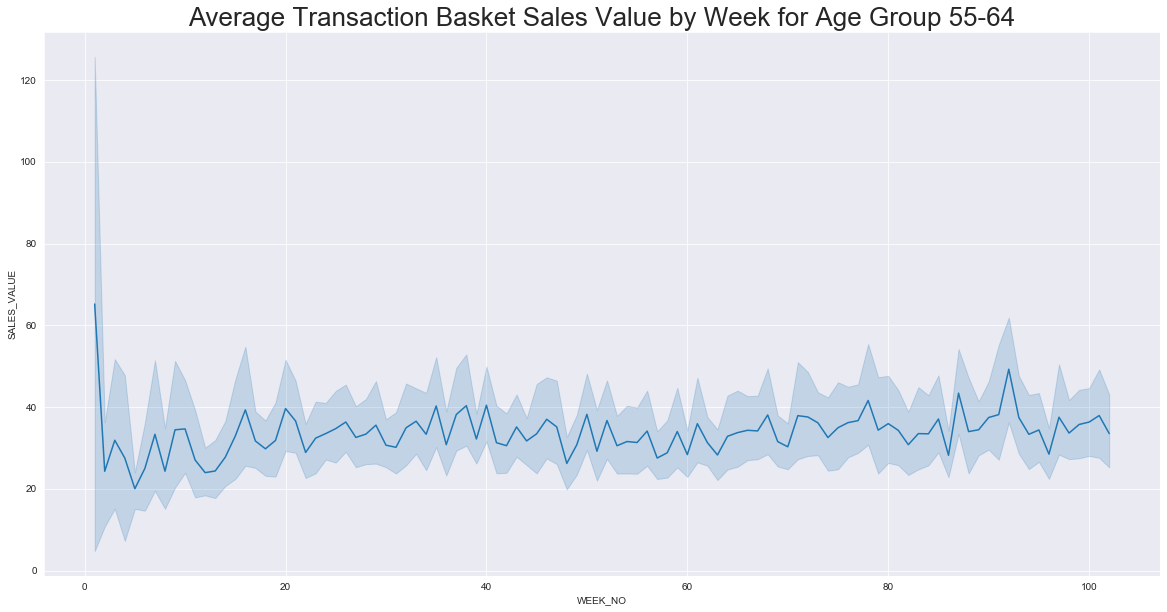

In [18]:
sns.set_style("darkgrid")

avg_weekly_sales_55_64 = age_55_64[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Age Group 55-64", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_55_64,
                  markers=True)

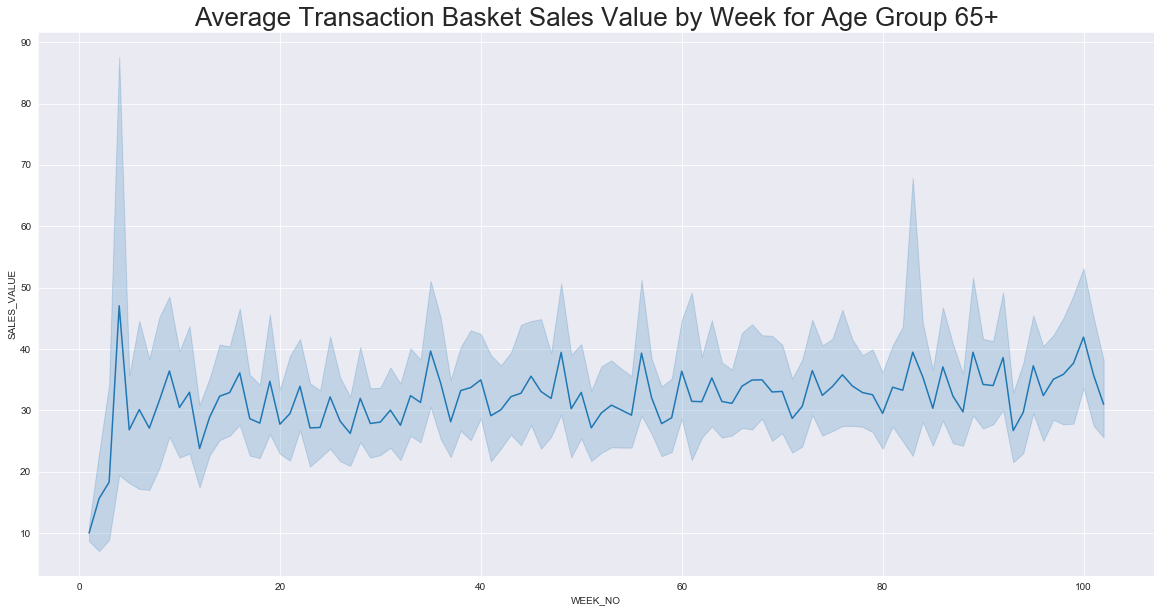

In [19]:
sns.set_style("darkgrid")

avg_weekly_sales_65 = age_65[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Age Group 65+", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_65,
                  markers=True)

## Weekly Spending By Income Groups


inc_15_24K = income_group_spending_dfs[2]



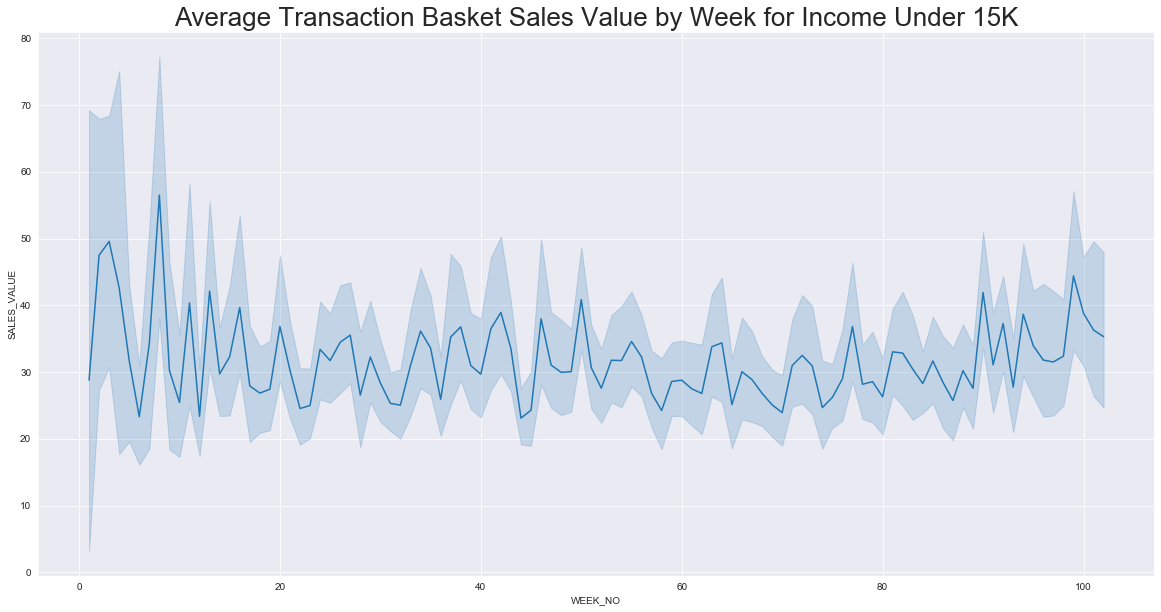

In [20]:
sns.set_style("darkgrid")

avg_weekly_sales_inc_Under_15K = inc_Under_15K[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Income Under 15K", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_inc_Under_15K,
                  markers=True)

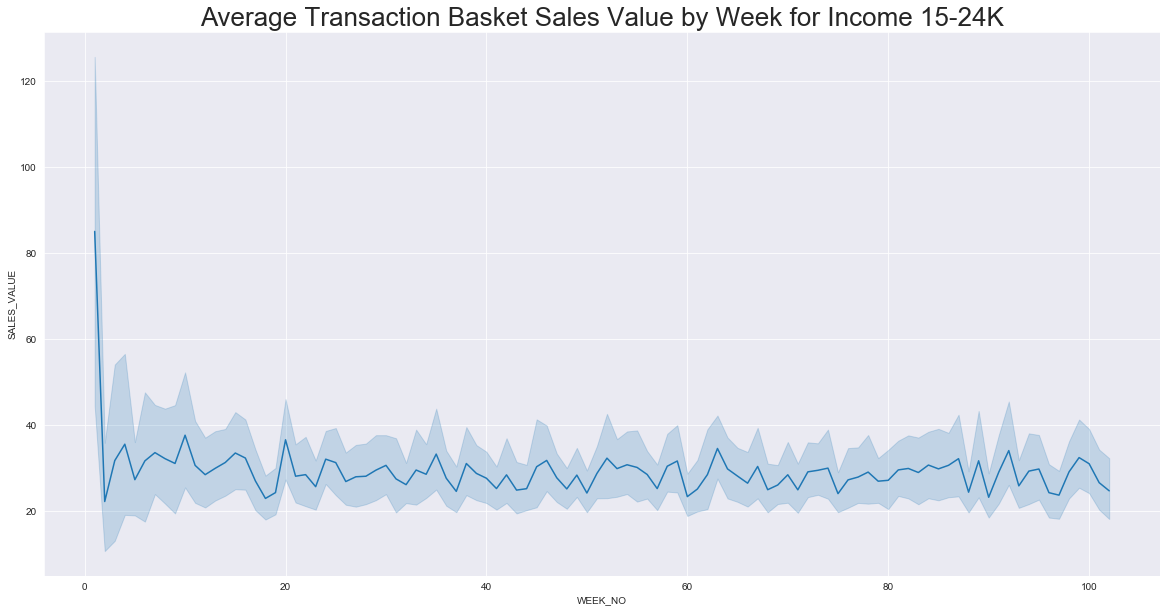

In [21]:
sns.set_style("darkgrid")

avg_weekly_sales_inc_15_24K = inc_15_24K[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Income 15-24K", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_inc_15_24K,
                  markers=True)

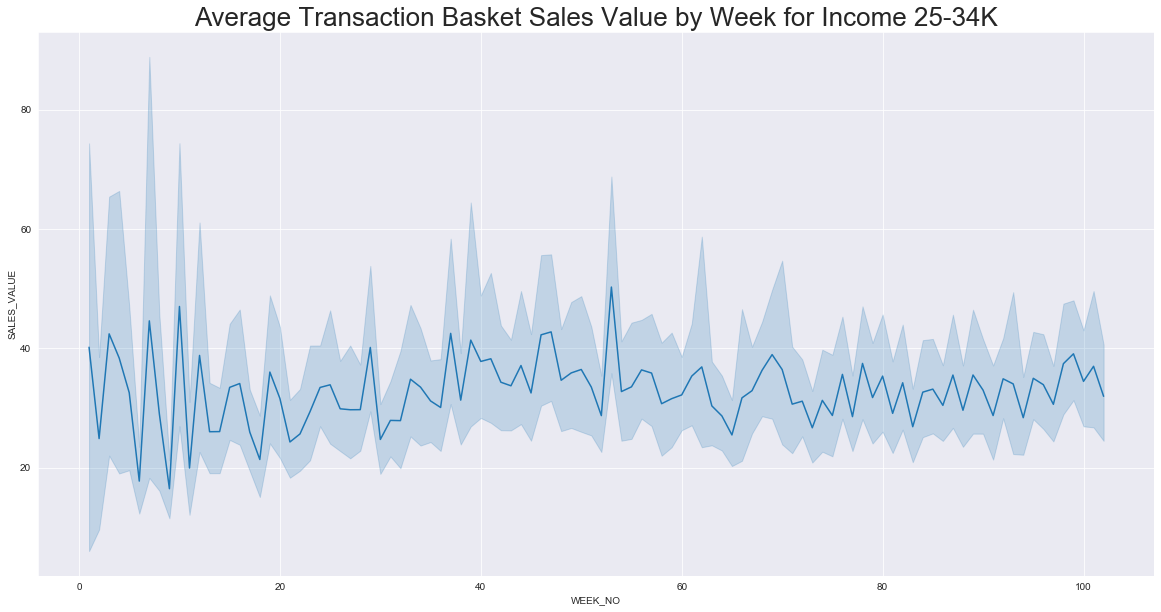

In [22]:
sns.set_style("darkgrid")

avg_weekly_sales_inc_25_34K = inc_25_34K[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Income 25-34K", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_inc_25_34K,
                  markers=True)

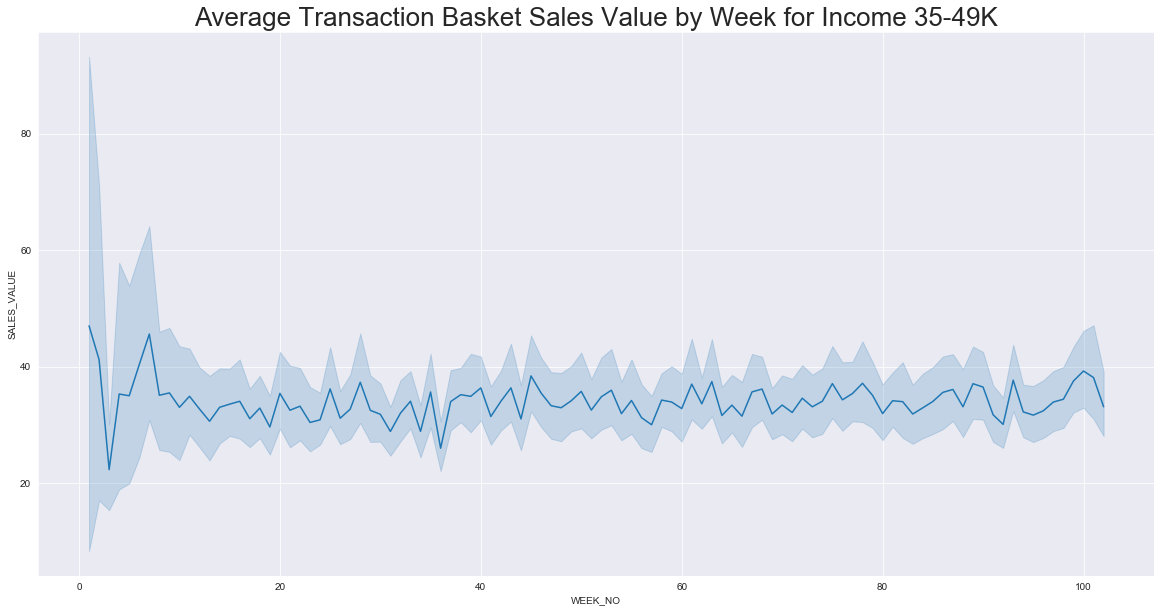

In [23]:
sns.set_style("darkgrid")

avg_weekly_sales_inc_35_49K = inc_35_49K[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Income 35-49K", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_inc_35_49K,
                  markers=True)

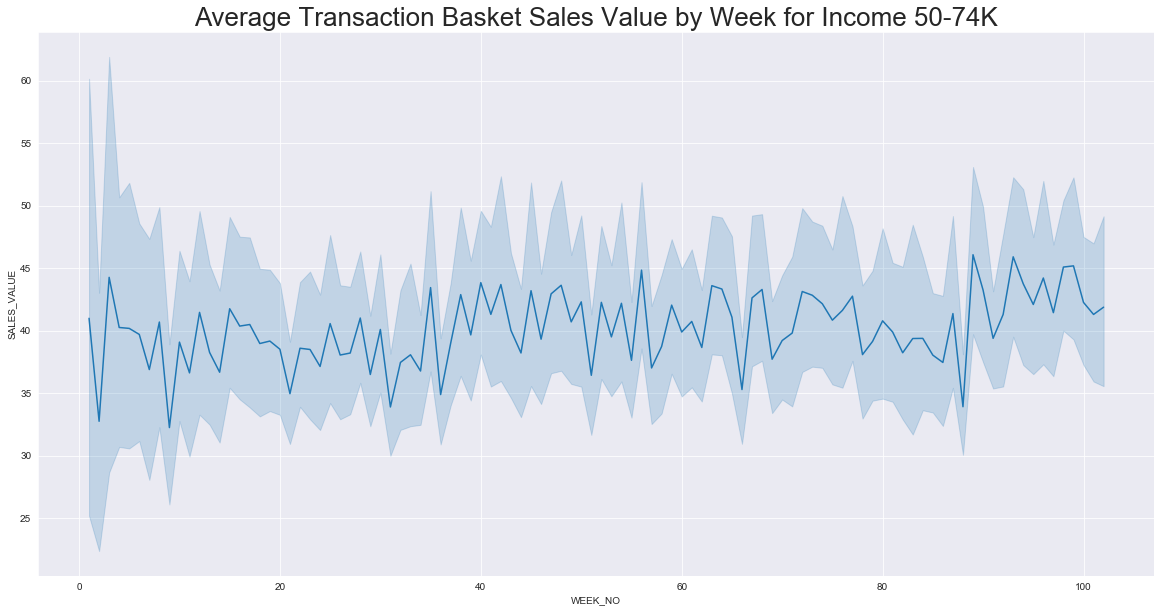

In [24]:
sns.set_style("darkgrid")

avg_weekly_sales_inc_50_74K = inc_50_74K[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Income 50-74K", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_inc_50_74K,
                  markers=True)

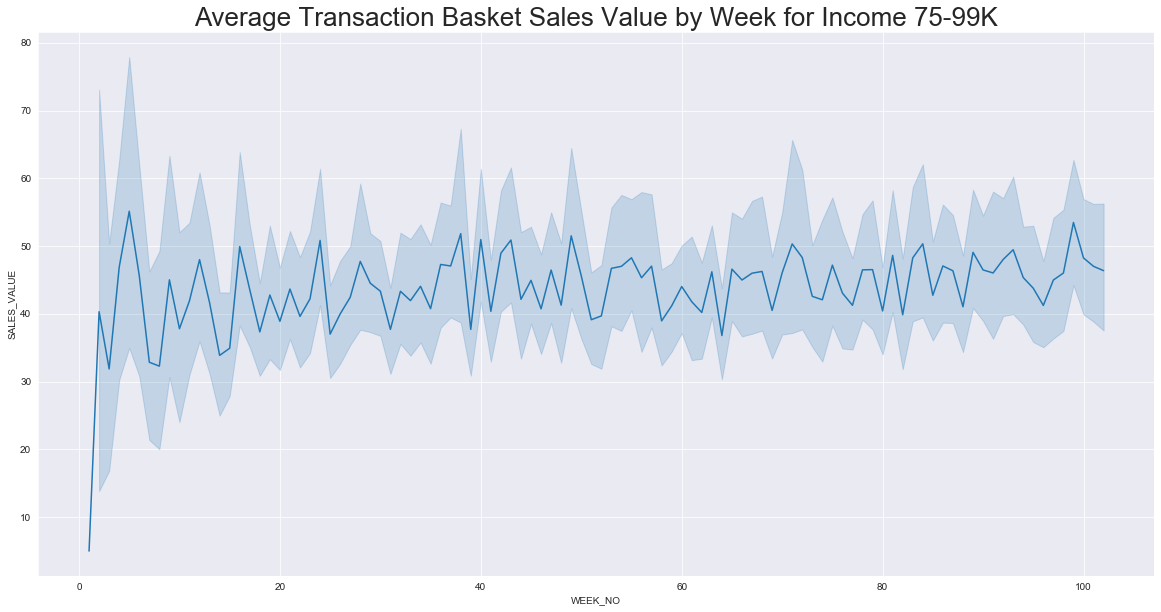

In [25]:
sns.set_style("darkgrid")

avg_weekly_sales_inc_75_99K = inc_75_99K[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Income 75-99K", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_inc_75_99K,
                  markers=True)

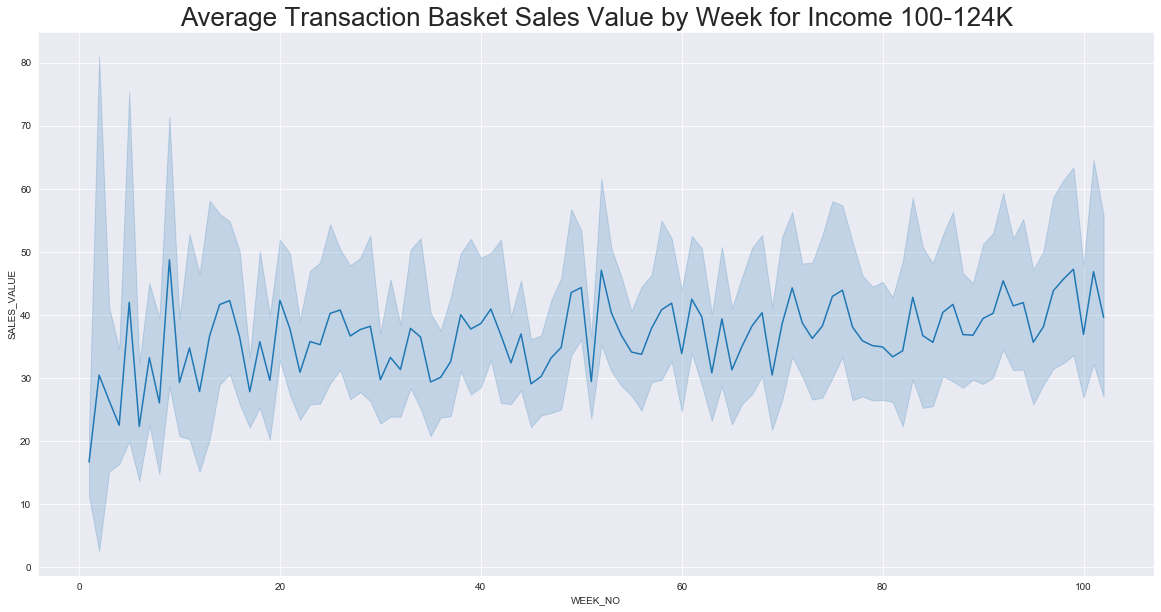

In [26]:
sns.set_style("darkgrid")

avg_weekly_sales_inc_100_124K = inc_100_124K[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Income 100-124K", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_inc_100_124K,
                  markers=True)

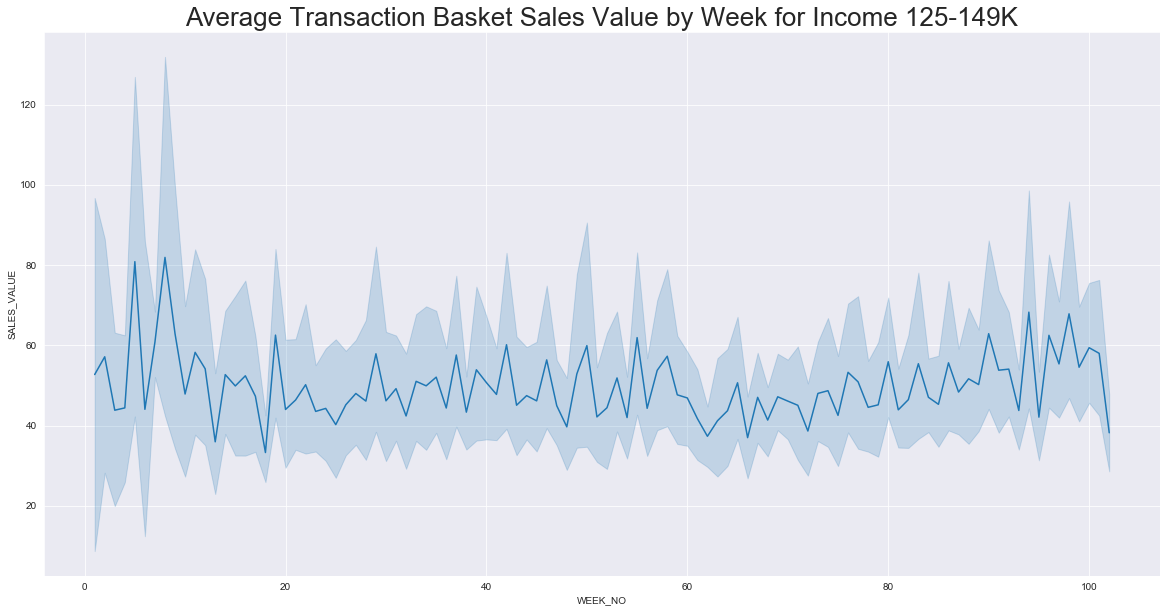

In [27]:
sns.set_style("darkgrid")

avg_weekly_sales_inc_125_149K = inc_125_149K[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Income 125-149K", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_inc_125_149K,
                  markers=True)

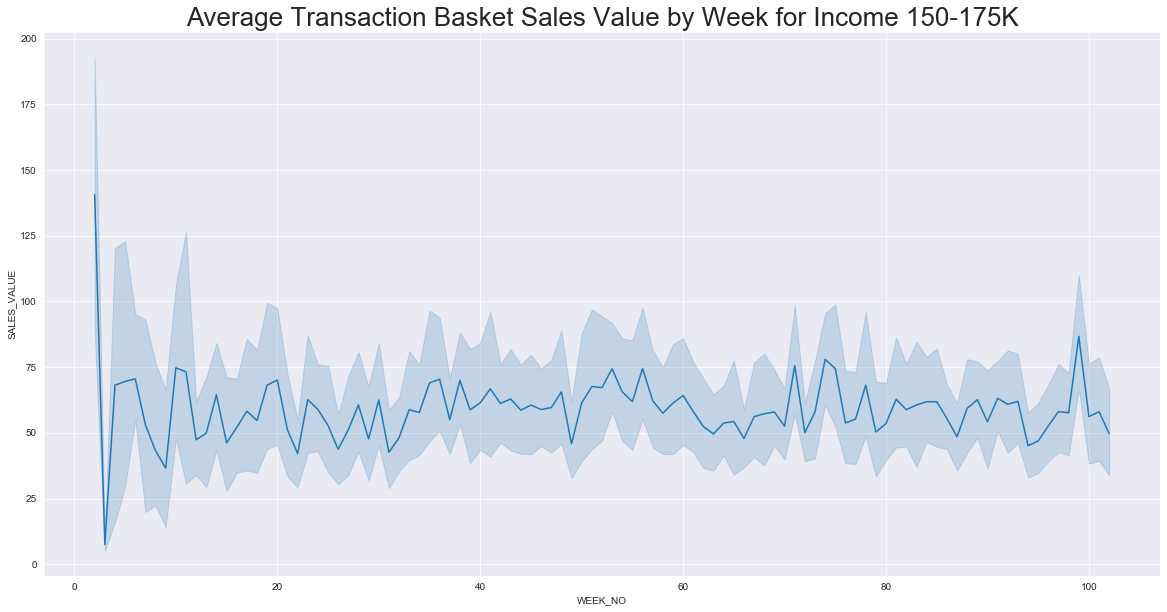

In [28]:
sns.set_style("darkgrid")

avg_weekly_sales_inc_150_174K = inc_150_174K[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Income 150-175K", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_inc_150_174K,
                  markers=True)

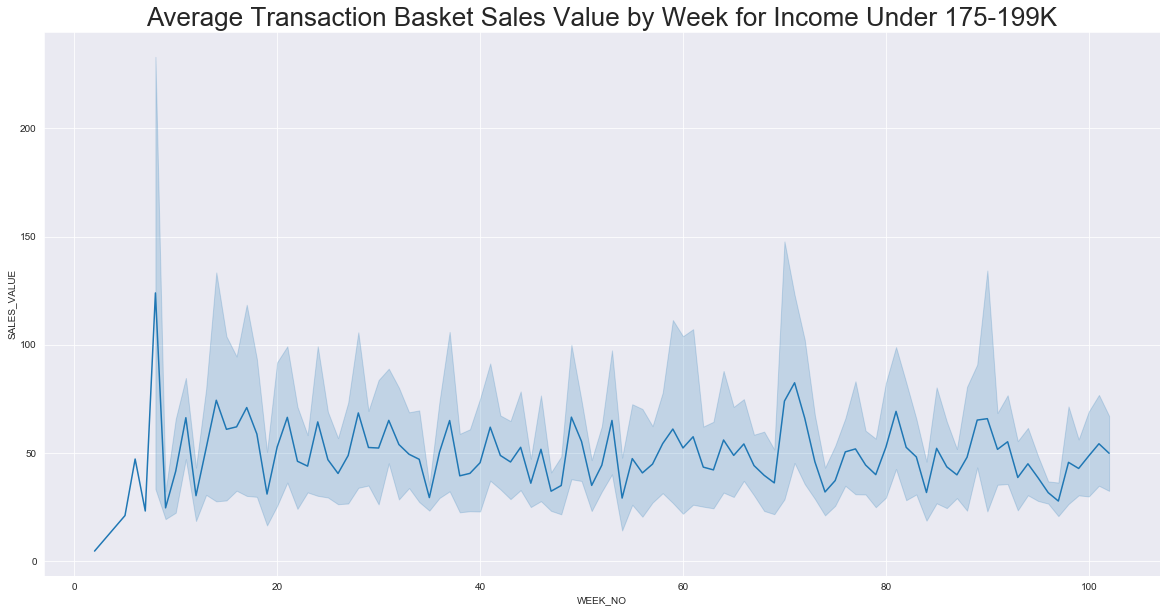

In [29]:
sns.set_style("darkgrid")

avg_weekly_sales_inc_175_199K = inc_175_199K[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Income Under 175-199K", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_inc_175_199K,
                  markers=True)

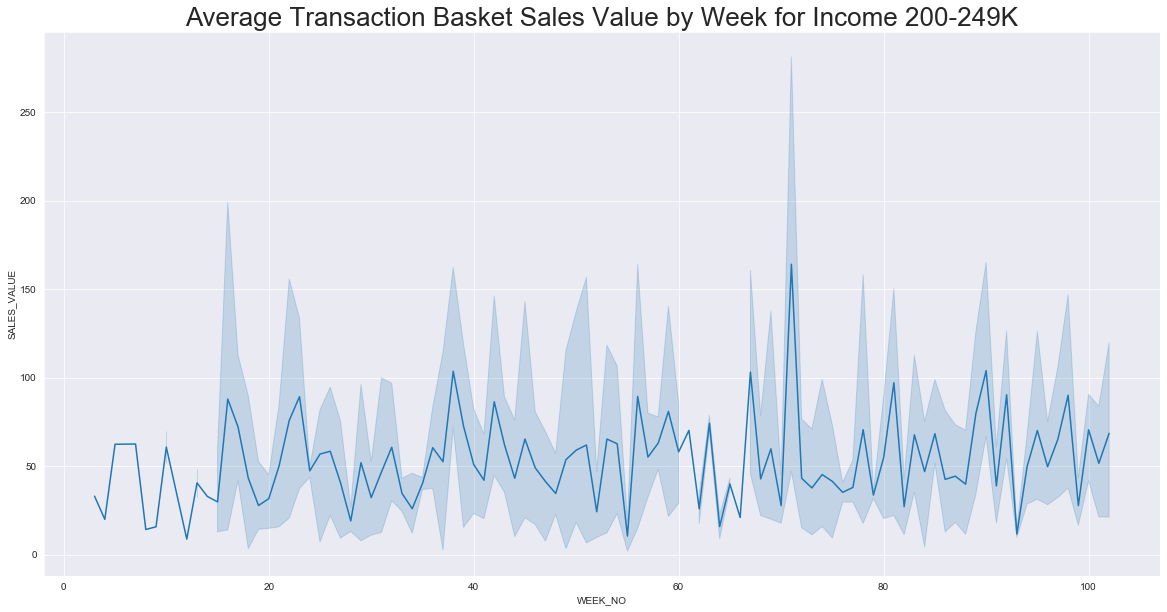

In [30]:
sns.set_style("darkgrid")

avg_weekly_sales_inc_200_249K = inc_200_249K[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Income 200-249K", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_inc_200_249K,
                  markers=True)

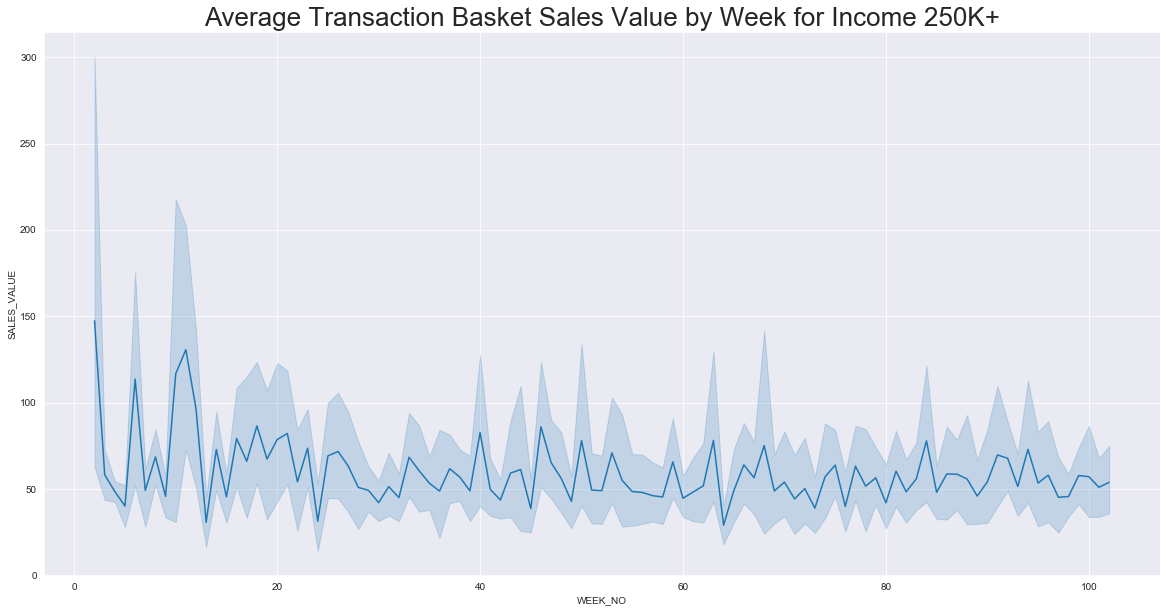

In [31]:
sns.set_style("darkgrid")

avg_weekly_sales_inc_250K = inc_250K[['WEEK_NO', 'SALES_VALUE', 'household_key']].groupby(['WEEK_NO', 'household_key']).mean().reset_index()
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value by Week for Income 250K+", size=26)
ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=avg_weekly_sales_inc_250K,
                  markers=True)

# 4. Plot Average Weekly Spending for a specific demographic group: Age Group (25-34) and Income Group 50-74K.

Previously we plotted the average weekly spending for each age and income group separately, but we can further filter and subset the data avaliable to see average weekly spending by specific age and income groups, namely households aged 25-34 in the income group of 50-74K/year.

Additionally we can use the campaign_desc and campaign_table datasets to determine the top ad campaigns that reached our target demographic group to see if spending patterns changed during the campaigns.

## Finding the households that meet our target demographic.

We can use either the age or income group dataframes and then filter for the households that meet our income and age demographic requirements with the following block of code:

The boolean check will return our households match from both age and income dataframes.

With the list household keys we've generated we can then filter the spending demographic dataframe for those specific households


In [32]:
print(sorted(inc_50_74K[inc_50_74K['AGE_DESC'] == '25-34'].household_key.unique()) == sorted(age_25_34[age_25_34['INCOME_DESC'] == '50-74K'].household_key.unique()))

hh_keys_age_25_34_inc_50_74K = list(age_25_34[age_25_34['INCOME_DESC'] == '50-74K'].household_key.unique())

target_demo_1 = spend_demo_data[spend_demo_data['household_key'].isin(hh_keys_age_25_34_inc_50_74K)]
target_demo_1.head()

True


,BASKET_ID,SALES_VALUE,household_key,DAY,STORE_ID,TRANS_TIME,WEEK_NO,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
9690,27637215343,10.00,166,55,447,1055,9,25-34,A,50-74K,Homeowner,2 Adults Kids,3,1
9691,27649217252,11.58,166,56,447,2034,9,25-34,A,50-74K,Homeowner,2 Adults Kids,3,1
9692,27744966210,12.00,166,64,447,1557,10,25-34,A,50-74K,Homeowner,2 Adults Kids,3,1
9693,28069172381,6.98,166,91,447,2218,14,25-34,A,50-74K,Homeowner,2 Adults Kids,3,1
9694,28154032081,14.04,166,97,447,1949,15,25-34,A,50-74K,Homeowner,2 Adults Kids,3,1


## Finding matching campaigns with campaign_desc and campaign_table

We can also use the list of household keys with the campaign_desc and campaign_table dataframes to find the campaigns that reached our target demographic group. 

The campaign_desc data frame include the start and end in days but we can create new features for the start and end week of each campaign.

In [33]:
campaign_desc['START_WEEK'] = campaign_desc['START_DAY'] / 7
campaign_desc['END_WEEK'] = campaign_desc['END_DAY'] / 7
campaign_desc.head()

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY,START_WEEK,END_WEEK
0,TypeB,24,659,719,94.142857,102.714286
1,TypeC,15,547,708,78.142857,101.142857
2,TypeB,25,659,691,94.142857,98.714286
3,TypeC,20,615,685,87.857143,97.857143
4,TypeB,23,646,684,92.285714,97.714286


## Campaign_table

Using the previously created list of household keys for our target demographic, we can find the top 5 campaigns that reached those households.

With the top 3 campaigns, we can use campaign_desc to find the start and end of each campaign

In [34]:
#  Find the campaigns that reached our target demographic
demo_campaigns = campaign_table[campaign_table['household_key'].isin(hh_keys_age_25_34_inc_50_74K)]

#  Find the top three campaigns that reached households in our list
demo_campaigns.CAMPAIGN.value_counts().head(3)

18    29
13    27
8     24
Name: CAMPAIGN, dtype: int64

In [35]:
campaign_18 = campaign_desc[campaign_desc['CAMPAIGN'] == 18]
campaign_13 = campaign_desc[campaign_desc['CAMPAIGN'] == 13]
campaign_8 = campaign_desc[campaign_desc['CAMPAIGN'] == 8]

## Plotting Weekly Spend For the Target Demographic During the Top Three Ad Campaigns

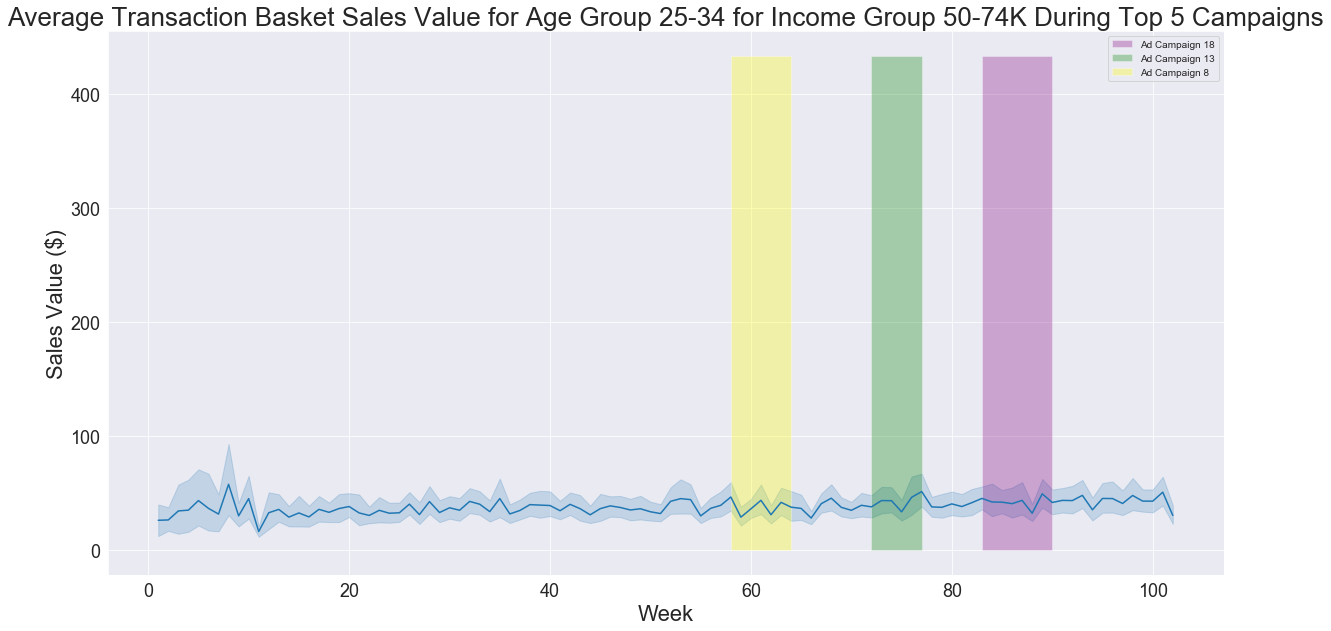

In [36]:
plt.figure(figsize=(20,10))
plt.title("Average Transaction Basket Sales Value for Age Group 25-34 for Income Group 50-74K During Top 5 Campaigns", size=26)

ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=target_demo_1,
                  markers=True)

campaign_18_active = np.arange(int(campaign_18['START_WEEK']), int(campaign_18['END_WEEK']))
campaign_13_active = np.arange(int(campaign_13['START_WEEK']), int(campaign_13['END_WEEK']))
campaign_8_active = np.arange(int(campaign_8['START_WEEK']), int(campaign_8['END_WEEK']))
y = target_demo_1.SALES_VALUE.max()

ax.fill_between(campaign_18_active, y, facecolor='purple', alpha=0.3, label='Ad Campaign 18')
ax.fill_between(campaign_13_active, y, facecolor='green', alpha=0.3, label='Ad Campaign 13')
ax.fill_between(campaign_8_active, y, facecolor='yellow', alpha=0.3, label='Ad Campaign 8')

ax.set_xlabel('Week', fontsize=22)
ax.set_ylabel('Sales Value ($)', fontsize=22)
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
plt.legend()

### Ad Campaign Notes: 

With the plot above, it does not appear that ad campaigns 18, 13, and 8 were succesful in increasing average weekly spend for the demographic group that we are looking at. 

However it is important to note that ad campaigns 18, 13, and 8 may not specifically targeted our demographic group. We can only say that campaigns 18, 13, and 8 were the most successful at reaching households in the demographic group aged 25-34 making 50-74K.

# 5. Plotting Spending Patterns of the Two Specific Households From the Target Demographic with top 2 Ad Campaigns

Below we've printed the first two households from our list of hh_key that fall into the target demographic. Using the data we plot the spending patterns of these two households along active ad campaigns that reached them. 

In [37]:
print(hh_keys_age_25_34_inc_50_74K[:2])
hh_key_166 = target_demo_1[target_demo_1['household_key'] == 166]
hh_key_256 = target_demo_1[target_demo_1['household_key'] == 256]

[166, 256]


## Household 166

Using the campaign data avaliable we can see that ad campaigns 13 and 8 were successful in reaching this household AND that there was a marked increased in weekly spending during the two campaigns.

In [38]:
hh_key_166 = target_demo_1[target_demo_1['household_key'] == 166]
campaign_table[campaign_table['household_key'] == 166]

,DESCRIPTION,household_key,CAMPAIGN
2795,TypeA,166,13
3917,TypeA,166,18


No handles with labels found to put in legend.


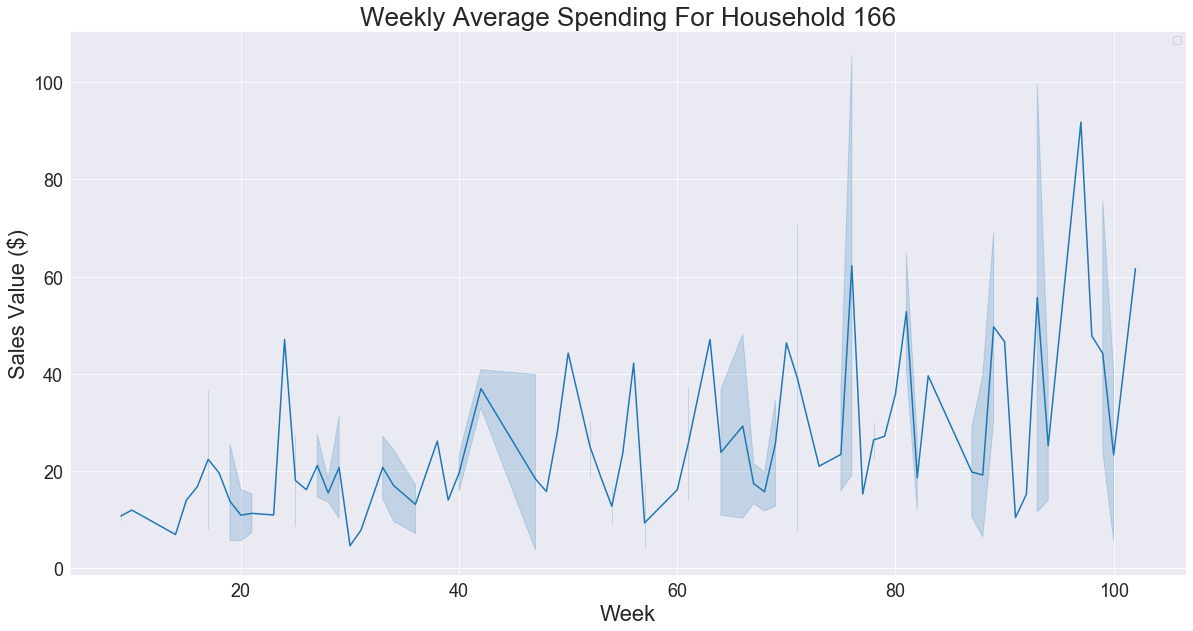

In [39]:
plt.figure(figsize=(20,10))
plt.title("Weekly Average Spending For Household 166", size=26)

ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=hh_key_166,
                  markers=True)

ax.set_xlabel('Week', fontsize=22)
ax.set_ylabel('Sales Value ($)', fontsize=22)
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.legend()

## Household 256

Using the ad campaign data we can see that household 256 was reached by 12 different ad campaigns and had a average weekly spending higher than 166.

In [40]:
hh_key_256 = target_demo_1[target_demo_1['household_key'] == 256]
campaign_table[campaign_table['household_key'] == 256]

,DESCRIPTION,household_key,CAMPAIGN
311,TypeA,256,26
686,TypeA,256,30
738,TypeA,256,8
1845,TypeA,256,13
2918,TypeA,256,18
4425,TypeB,256,7
5477,TypeB,256,16
5632,TypeB,256,17
6069,TypeB,256,22
6465,TypeB,256,25


No handles with labels found to put in legend.


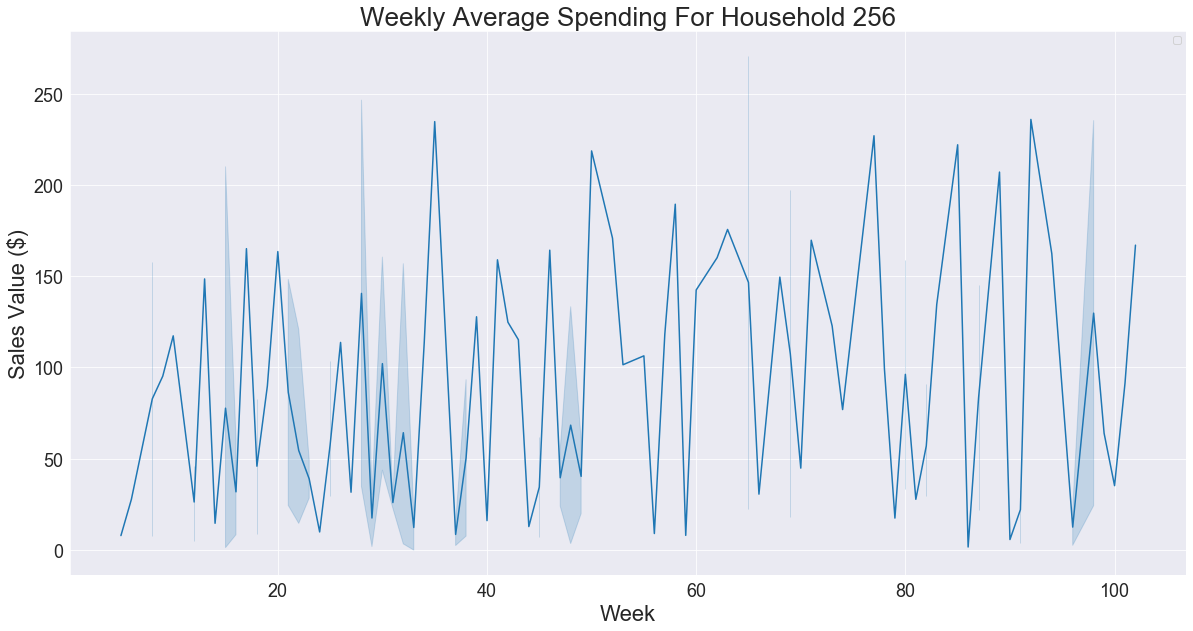

In [42]:
plt.figure(figsize=(20,10))
plt.title("Weekly Average Spending For Household 256", size=26)

ax = sns.lineplot(x='WEEK_NO', y='SALES_VALUE',
                  data=hh_key_256,
                  markers=True)

ax.set_xlabel('Week', fontsize=22)
ax.set_ylabel('Sales Value ($)', fontsize=22)
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.legend()

# Conclusion

The notebook has only consisted of EDA on weekly spending by specific demographic groups and households during active campaigns.

I hope to expand on this notebook and determine whether or not ad campaigns were successful in increasing the average weekly and daily of households they reached. 

### More to come in the future!

### If you liked this notebook or see any issues please upvote or message me

### Thanks!

# 6. How do you define a successful campaign? Increase customer spending? Or increased customer visit?  

If assuming that a successful ad campaign is increased customers sending we could look at whether the targeted demographic of each ad campaign average weekly spend has increased during the ad campaign.

If assuming that a successful ad campaign is followed by more visit in store we would have to determine 